Copyright 2023 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [1]:
# Dependencies are installed via uv
# Run: uv sync --group dev
# Then execute notebook with: uv run jupyter notebook

In [2]:
from jax import config
config.update('jax_enable_x64', True)

import jax.numpy as jnp
import jax

import matplotlib
import matplotlib.pyplot as plt

from importlib import reload

In [3]:
from trajax import integrators
from trajax.core import TrajectoryProblem
from trajax.solvers import ConstrainedILQROptimizer
from trajax.integrators import euler
from trajax.utils import get_s1_wrapper

# Define Problem

## Setup Obstacle environment

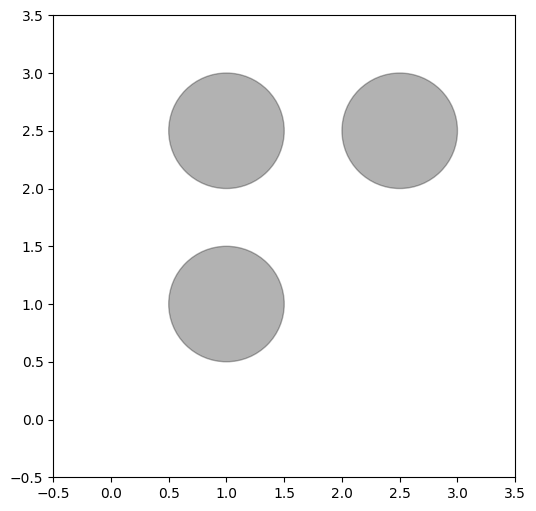

In [4]:
# @title {vertical-output: true}

obs = [(jnp.array([1., 1.]), 0.5),
          (jnp.array([1, 2.5]), 0.5),
          (jnp.array([2.5, 2.5]), 0.5)]

def render_scene():
  # Setup obstacle environment for state constraint
  world_range = (jnp.array([-0.5, -0.5]), jnp.array([3.5, 3.5]))

  fig = plt.figure(figsize=(6,6))
  ax = fig.add_subplot(111)
  plt.grid(False)

  for ob in obs:
    ax.add_patch(plt.Circle(ob[0], ob[1], color='k', alpha=0.3))
  ax.set_xlim([world_range[0][0], world_range[1][0]])
  ax.set_ylim([world_range[0][1], world_range[1][1]])

  ax.set_aspect('equal')
  return fig, ax

_ = render_scene()

## Setup Dynamics, cost, constraints

In [5]:
# Setup discrete-time dynamics
def car_ode(x, u, t):
  del t
  return jnp.array([x[3] * jnp.sin(x[2]),
                    x[3] * jnp.cos(x[2]),
                    x[3] * u[0],
                    u[1]])
dt = 0.05
dynamics_fn = integrators.euler(car_ode, dt=dt)

# Create a dynamics function that accepts params (for trajectory problem compatibility)
def dynamics(x, u, t, params=None):
  return dynamics_fn(x, u, t)

# Constants
n, m, T = (4, 2, 40)

# Indices of state corresponding to S1 sphere constraints
s1_indices = (2,)
state_wrap = get_s1_wrapper(s1_indices)


# Cost function.
R = jnp.diag(jnp.array([0.2, 0.1]))
Q_T = jnp.diag(jnp.array([50., 50., 50., 10.]))
goal_default = jnp.array([3., 3., jnp.pi/2, 0.])

@jax.jit
def cost(x, u, t, params=None, goal=goal_default):
  stage_cost = dt * jnp.vdot(u, R @ u)
  delta = state_wrap(x - goal)
  term_cost = jnp.vdot(delta, Q_T @ delta)
  return jnp.where(t == T, term_cost, stage_cost)

# Control box bounds
control_bounds = (jnp.array([-jnp.pi/3., -6.]),
                  jnp.array([jnp.pi/3., 6.]))

# Obstacle avoidance constraint function
# Note: Constraints in augmented Lagrangian must be in form c(x) <= 0 (satisfied when negative or zero)
def obs_constraint(pos):
  def avoid_obs(pos_c, ob):
    delta_body = pos_c - ob[0]
    # Constraint: radius^2 - distance^2 <= 0 (satisfied when distance >= radius)
    delta_dist_sq = jnp.vdot(delta_body, delta_body)
    return (ob[1]**2) - delta_dist_sq
  return jnp.array([avoid_obs(pos, ob) for ob in obs])

# State constraint function
@jax.jit
def state_constraint(x, u, t, params=None):
  # Signature matches problem/optimizer expectations: (x, u, t, params)
  del u, t, params
  pos = x[0:2]
  return obs_constraint(pos)

# Define Solver

In [6]:
# Define Solver - Using ConstrainedILQROptimizer
# Note: This is a simplified example using the new refactored API
# The old ShootSQP solver is not available in this refactored version
# For constrained trajectory optimization, use ConstrainedILQROptimizer

from trajax.solvers import ConstrainedILQROptimizer
from trajax.core import TrajectoryProblem

# Create trajectory problem
problem = TrajectoryProblem(
    state_dim=n,
    control_dim=m,
    horizon=T,
    dynamics=dynamics,  # Now accepts (x, u, t, params)
    cost=cost,  # Now accepts (x, u, t, params)
    inequality_constraint=state_constraint,  # Now accepts (x, t, params)
)

# Create solver
solver = ConstrainedILQROptimizer(
    maxiter_al=10,  # Augmented Lagrangian outer iterations
    maxiter_ilqr=100,  # iLQR inner iterations per AL iteration
    constraints_threshold=1e-3,
)

print("Note: The refactored API uses a different interface than the old ShootSQP.")
print("See examples in README.md for the new usage pattern.")

Note: The refactored API uses a different interface than the old ShootSQP.
See examples in README.md for the new usage pattern.


In [7]:
# API Migration Notes:
# Old: solver.solve(x0, U0, X0)
# New: result = solver.solve(problem, x0, U0, params)
# See README.md and examples/ directory for updated examples

# Solve

## Set initial conditions and guess

In [8]:
# Set initial conditions and problem parameters
# x0 = jnp.zeros((n,))
# x0 = jnp.array([0.25, 1.75, 0., 0.])
x0 = jnp.array([1.75, 1.0, 0., 0.])
U0 = jnp.zeros((T, m))
X0 = None

In [9]:
# Optional: Provide a rough initial state trajectory guess
# This can help with convergence (only U0 is strictly required)
# X0 = np.concatenate((
#     np.linspace(x0[:2], goal_default[:2], T+1),
#     np.zeros((T+1, 2))
# ))

## Solve

In [10]:
# Run for one iteration to jit first
_ = solver.solve(problem, x0, U0, params=(), options={'maxiter_al': 1})

In [11]:
# Run to completion
soln = solver.solve(problem, x0, U0, params=())

In [12]:
print(f"Iterations: {soln.info.get('iterations', 'N/A')}, Objective: {soln.obj}")
print(f"Converged: {soln.converged}")
print(f"Status: {soln.status}")

Iterations: N/A, Objective: 1.3740673988069014
Converged: True
Status: SolverStatus.SOLVED


# Plot solution

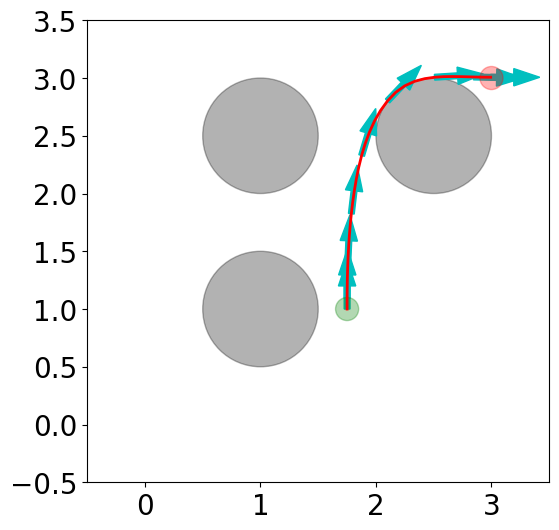

In [13]:
#@title {vertical-output: true}
%matplotlib inline

plt.rcParams.update({'font.size': 20})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

fig, ax = render_scene()
X = soln.X
U = soln.U
T = soln.horizon
ax.plot(X[:, 0], X[:, 1], 'r-', linewidth=2)

for t in jnp.arange(0, T+1, 5):
  ax.arrow(X[t, 0], X[t, 1],
      0.2 * jnp.sin(X[t, 2]), 0.2 * jnp.cos(X[t, 2]),
      width=0.05, color='c')

# Start
ax.add_patch(plt.Circle([x0[0], x0[1]], 0.1, color='g', alpha=0.3))
# End
ax.add_patch(plt.Circle([goal_default[0], goal_default[1]], 0.1, color='r', alpha=0.3))

ax.set_aspect('equal')

Text(0.5, 0, 'Time [s]')

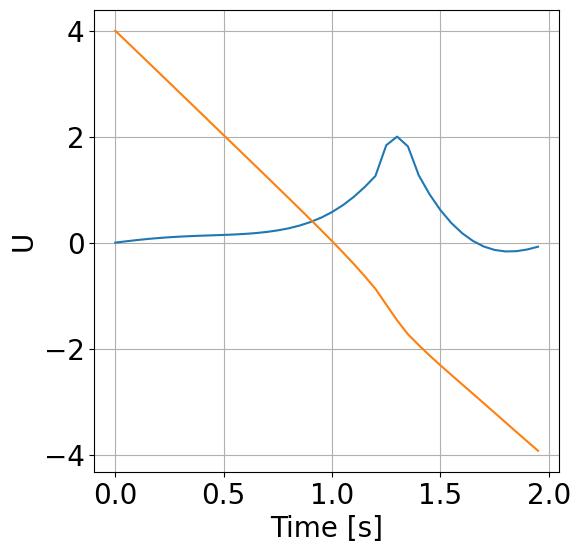

In [14]:
# @title {vertical-output: true}
%matplotlib inline

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.grid(True)
U = soln.U
T = soln.horizon
plt.plot((jnp.arange(T))*dt, U, markersize=5)
ax.set_ylabel('U')
ax.set_xlabel('Time [s]')

# Plot solver progress

In [15]:
import seaborn as sns
colors = sns.color_palette("tab10")

In [16]:
history = soln.info.get('history', {})
if history:
    print("History keys available:", history.keys())
else:
    print("No history data available (solver may not track history by default)")

No history data available (solver may not track history by default)


In [17]:
#@title {vertical-output: true}
%matplotlib inline

history = soln.info.get('history', {})

if history:
    plt.rcParams.update({'font.size': 24})
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    
    # Step size
    if 'steplength' in history:
        axs[0][0].plot(history['steplength'], color=colors[0], linewidth=2)
        axs[0][0].set_title('Step size')
        axs[0][0].grid(True)
    else:
        axs[0][0].text(0.5, 0.5, 'No step size data', ha='center', va='center')
    
    # Objective
    if 'obj' in history:
        axs[0][1].plot(history['obj'], color=colors[0], linewidth=2)
        axs[0][1].set_title('Objective')
        axs[0][1].set_yscale('log')
        axs[0][1].grid(True)
    else:
        axs[0][1].text(0.5, 0.5, 'No objective data', ha='center', va='center')
    
    # Constraint violation
    if 'min_viol' in history:
        axs[1][0].plot(history['min_viol'], color=colors[0], linewidth=2)
        axs[1][0].set_title('Min constraint viol.')
        axs[1][0].set_xlabel('Iteration')
        axs[1][0].grid(True)
    else:
        axs[1][0].text(0.5, 0.5, 'No constraint data', ha='center', va='center')
    
    # Solver errors (if available)
    if 'ddp_err' in history:
        axs[1][1].plot(history['ddp_err'], color=colors[0], linewidth=2)
        axs2 = axs[1][1].twinx()
        axs2.plot(history['ddp_err_grad'], color=colors[1], linewidth=2)
        axs2.set_yscale("log")
        axs[1][1].set_title('DDP errors')
        axs[1][1].set_xlabel('Iteration')
        axs[1][1].grid(True)
    else:
        axs[1][1].text(0.5, 0.5, 'No DDP error data', ha='center', va='center')
else:
    print("No history data available")

No history data available
